In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

## Linear advection equation 

We want to solve the incompressible Euler equations in two-dimensions. Unlike the compressible equations, where we can write them in one dimension, the incompressible Euler requires at least two-dimensions to have non trivial solutions.

The basic algorithm is:

1. Create the time-centered advective velocities through the faces of the zones.
2. Project the advective velocities such that they obey the velocity constraint
3. Construct the time-centered interface states of all quantities on the faces of the zones using the advective velocity.
4. Update the velocity to the new time. This is defines the provisional velocity field—it does not yet satisfy the constraint.
5. Enforce the velocity constraint by projecting the velocity.

Parts two and five are the new ones. Part five is present in every incompressible method that generates an intermediate/provisional velocity field, and then corrects for incompressibility. 

Part two is not present in all incompressible codes. It is is introduced because when interpolating to create our advective velocities we are not guaranteed to have an incompressible flow. In theory we could write the equations in another manner such that this interpolation is not there, or even go without this step, as the book says- this would just make our code a little bit more unstable, and lower the CFL condition. However, if we do not make our velocities divergence free- we lose conservation of mass, and thus we lose all possible conservation properties of the scheme. 

### Code

We write down routines to create the grid, set the boundary conditions and initialize the state separately

In [2]:
def create_grid(ni,di):
    return np.arange(ni)*di

In [3]:
def set_periodic_bc(mm):
    mm[0,:]=mm[-1,:]
    mm[:,0]=mm[:,-1]
    return mm

In [4]:
def initialize_state(nx,ny,x,y):
    X,Y=np.meshgrid(x,y)
    u=1.-2.*np.cos(2.*np.pi*X)*np.sin(2.*np.pi*Y)
    v=1.+2.*np.sin(2.*np.pi*X)*np.cos(2.*np.pi*Y)
    return u,v

In [66]:
def calculate_timestep(C,u,dx,v,dy):
    return np.min(np.abs(np.array([dx*C/u,dy*C/v])))

In [42]:
def solve_periodic_poisson(rhs,dx,dy,imax=1000,tol=1e-6):
    # This for now assumes dx=dy
    phi=np.zeros(rhs.shape)
    resi_norm=1.; niter = 0;
    while ((resi_norm > tol) and (niter < imax)):
        stencil=np.roll(phi,1,axis=0)+np.roll(phi,-1,axis=0)+np.roll(phi,1,axis=1)+np.roll(phi,-1,axis=1)
        res= rhs-(stencil-4*phi)/(dx*dx)
        phi=0.25*(stencil-dx*dx*rhs)
        resi_norm=np.linalg.norm(res)*dx*dx
        niter=niter+1

    return phi

## Step 1: Calculate the advective velocities

This is slightly more complicated than HW8 because we will not use Strang splitting, and will account for the transverse fluxes.

We calculate the  'left' and 'right' states for the ($i\pm1/2,j)$. We will follow Eq. (14.30) and (14.32).

In [29]:
def calculate_L_x(u,v,dt,dx):
    dudx=(np.roll(u,-1,axis=0)-np.roll(u,1,axis=0))/(2.*dx)
    dvdx=(np.roll(v,-1,axis=0)-np.roll(v,1,axis=0))/(2.*dx)
    return u+dx/2.*(1.-dt/dx*u)*dudx,v+dx/2.*(1.-dt/dx*u)*dvdx

In [30]:
def calculate_R_x(u,v,dt,dx):
    dudx=(np.roll(u,-1,axis=0)-np.roll(u,1,axis=0))/(2.*dx)
    dvdx=(np.roll(v,-1,axis=0)-np.roll(v,1,axis=0))/(2.*dx)
    return np.roll(u-dx/2.*(1.+dt/dx*u)*dudx,-1,axis=0),np.roll(v-dx/2.*(1.+dt/dx*u)*dvdx,-1,axis=0)

We calculate the  'left' and 'right' states for the ($i,j\pm1/2)$ with Strang splitting, it becomes the same as earlier.

In [31]:
def calculate_L_y(u,v,dt,dy):
    dudy=(np.roll(u,-1,axis=1)-np.roll(u,1,axis=1))/(2.*dy)
    dvdy=(np.roll(v,-1,axis=1)-np.roll(v,1,axis=1))/(2.*dy)
    return u+dy/2.*(1.-dt/dy*v)*dudy,v+dy/2.*(1.-dt/dy*v)*dvdy

In [32]:
def calculate_R_y(u,v,dt,dy):
    dudy=(np.roll(u,-1,axis=1)-np.roll(u,1,axis=1))/(2.*dy)
    dvdy=(np.roll(v,-1,axis=1)-np.roll(v,1,axis=1))/(2.*dy)
    return np.roll(u-dy/2.*(1.+dt/dy*v)*dudy,-1,axis=1),np.roll(v-dy/2.*(1.+dt/dy*v)*dvdy,-1,axis=1)

We calculate the advective velocities using the left and right states. We define our Riemann solver using 14.38

In [33]:
def riemann_problem(ql,qr):
    result=qr.copy()
    nx=qr.shape[0]
    ny=qr.shape[1]
    for i in range(nx):
        for j in range(ny):
            if (ql[i,j]>0. and (ql[i,j]+qr[i,j])>0.):
                result[i,j]=ql[i,j]
            elif (ql[i,j]<=0. and qr[i,j] >= 0.):
                result[i,j]=0.
            
    return result

and the Upwinding function using 14.41:

In [34]:
def upwinding(sadv,ql,qr):
    nx=sadv.shape[0]
    ny=sadv.shape[1]
    uint = np.zeros([nx,ny])
    for i in range(nx):
        for j in range(ny):
            if (sadv[i,j]>0.0001):
                uint[i,j]=ql[i,j]
            elif(sadv[i,j]<0.0001):
                uint[i,j]=qr[i,j]
                
    return uint

In [35]:
def calc_adv_velocities(u,v,p,dx,dy,dt):
    
    uhatiL,vhatiL=calculate_L_x(u,v,dt,dx)
    uhatiR,vhatiR=calculate_R_x(u,v,dt,dx)
    uhatjL,vhatjL=calculate_L_y(u,v,dt,dy)
    uhatjR,vhatjR=calculate_R_y(u,v,dt,dy)
    
    uhadv=riemann_problem(uhatiL,uhatiR)
    vhadv=riemann_problem(vhatjL,vhatjR)

    uinti=upwinding(uhadv,uhatiL,uhatiR)
    uintj=upwinding(uhadv,uhatjL,uhatjR)
    vinti=upwinding(vhadv,vhatiL,vhatiR)
    vintj=upwinding(vhadv,vhatjL,vhatjR)

    tfluxi=dt/2.*(0.5*(np.roll(vhadv,1,axis=1)+vhadv))*(uintj-np.roll(uintj,1,axis=1)/dy)-dt/2.*(np.roll(p,-1,axis=0)-np.roll(p,1,axis=0))/(2.*dx)
    tfluxj=dt/2.*(0.5*(np.roll(uhadv,1,axis=0)+uhadv))*(vintj-np.roll(vintj,1,axis=1)/dy)-dt/2.*(np.roll(p,-1,axis=1)-np.roll(p,1,axis=1))/(2.*dy)
    uiL = uhatiL - tfluxi
    uiR = uhatiR - np.roll(tfluxi,-1,axis=0)
    vjL = vhatiL - tfluxj
    vjR = vhatiL - np.roll(tfluxj,-1,axis=1)
    uadv=riemann_problem(uiL,uiR)
    vadv=riemann_problem(uiL,uiR)
    return uadv, vadv

## Step 2-3: Correct advective/MAC velocities & Recalculate Interface velocities

These steps are optional, in the sense we could just go with the advective velocities from above, and use these to solve the ''upwind'' function, to determine the interface states. As discussed, this makes the code more unstable. 

This corrects the MAC advective velocities.

In [44]:
def corr_adv_velocities(uadv,vadv,dx,dy):
    div= (uadv-np.roll(uadv,1,axis=0))/dx+(vadv-np.roll(vadv,1,axis=1))/dy
    phicorr=solve_periodic_poisson(div,dx,dy)
    uadvc = uadv - (np.roll(phicorr,-1,axis=0)-phicorr)/dx
    vadvc = vadv - (np.roll(phicorr,-1,axis=1)-phicorr)/dy
    return uadvc,vadvc

Now I go back, and recalculate the two velocities at the four interfaces using the upwinding function with the corrected advective velocity.

In [37]:
def calc_corr_velocities(u,v,p,uadvc,vadvc,dx,dy,dt):
    uhatiL,vhatiL=calculate_L_x(u,v,dt,dx)
    uhatiR,vhatiR=calculate_R_x(u,v,dt,dx)
    uhatjL,vhatjL=calculate_L_y(u,v,dt,dy)
    uhatjR,vhatjR=calculate_R_y(u,v,dt,dy)
    uinti=upwinding(uadvc,uhatiL,uhatiR)
    uintj=upwinding(uadvc,uhatjL,uhatjR)
    vinti=upwinding(vadvc,vhatiL,vhatiR)
    vintj=upwinding(vadvc,vhatjL,vhatjR)
    return uinti,uintj,vinti,vintj

## Step 4:  Provisional update

With this, I can now calculate the fluxes for the advective term- and obtain a provisional, non-solenoidal field. We will use the $u^{\star\star}$ formulation, with no pressure gradient.

In [38]:
def calc_prov_velocities(u,v,uinti,uintj,vinti,vintj,uadvc,vadvc,dx,dy,dt):
    Au = 0.5*(uadvc+np.roll(uadvc,1,axis=0))*(uinti-np.roll(uinti,1,axis=0))/dx+0.5*(vadvc+np.roll(vadvc,1,axis=1))*(uinti-np.roll(uinti,1,axis=1))/dy
    Av = 0.5*(uadvc+np.roll(uadvc,1,axis=0))*(vinti-np.roll(vinti,1,axis=0))/dx+0.5*(vadvc+np.roll(vadvc,1,axis=1))*(vinti-np.roll(vinti,1,axis=1))/dy
    ustar = u-dt*Au
    vstar = v-dt*Av
    return ustar,vstar

## Step 5: Correct non-solenoidal fields

We finally correct the non-solenoidal field, and in this step we calculate the pressure for the next time-step.

In [39]:
def corr_prov_velocities(u,v,ustar,vstar,dx,dy):
    div= (np.roll(uadv,-1,axis=0)-np.roll(uadv,1,axis=0))/dx+(np.roll(vadv,-1,axis=0)-np.roll(vadv,1,axis=1))/dy
    phi=solve_periodic_poisson(div,dx,dy)
    u = ustar - dt*(np.roll(phi,-1,axis=0)-np.roll(phi,1,axis=0))/dx
    v = vstar - dt*(np.roll(phi,-1,axis=1)-np.roll(phi,1,axis=1))/dy
    p = phi.copy()
    return u,v,p

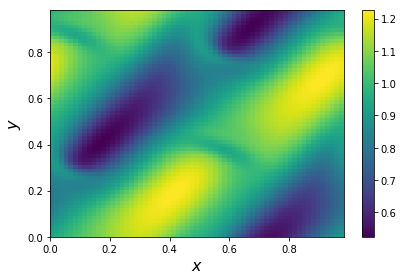

In [77]:
t0=0.; tmax=1.;
nx=64; u=1.;
ny=64; v=0.5;
xmin=0.; xmax=1.
dx=(xmax-xmin)/(nx)
x=create_grid(nx+1,dx)
xm=0.5*(x[:-1]+x[1:])
ymin=0.; ymax=1.
dy=(xmax-xmin)/(ny)
y=create_grid(ny+1,dy)
ym=0.5*(y[:-1]+y[1:])
u0,v0=initialize_state(nx+1,ny+1,xm,ym)
#u0=set_periodic_bc(u0)
#v0=set_periodic_bc(v0)
t=t0; nt=0
u=u0.copy()
v=v0.copy()

p=np.zeros([nx,ny])
#p = set_periodic_bc(p)
C=0.3
ntmax = 500
while (t < tmax) and (nt < ntmax):
    dt=calculate_timestep(C,u,dx,v,dy)
    uadv, vadv=calc_adv_velocities(u,v,p,dx,dy,dt)
    uadvc, vadvc=corr_adv_velocities(uadv,vadv,dx,dy)
    uinti, uintj, vinti, vintj = calc_corr_velocities(u,v,p,uadvc,vadvc,dx,dy,dt)
    ustar, vstar = calc_prov_velocities(u,v,uinti,uintj,vinti,vintj,uadvc,vadvc,dx,dy,dt)
    u,v,p =corr_prov_velocities(u,v,ustar,vstar,dx,dy)
#    u = set_periodic_bc(u)
#    v = set_periodic_bc(v)
#    p = set_periodic_bc(p)
    t += dt
    nt += 1
    
plt.pcolormesh(x[:nx],y[:ny],u[:nx,:ny])
plt.xlabel("$x$", fontsize=16)
plt.ylabel("$y$", fontsize=16)
#plt.gca().axis_equal()
plt.colorbar()
plt.tight_layout()
plt.show()

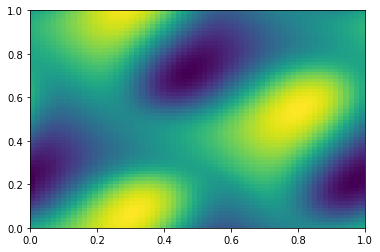

In [75]:
plt.pcolormesh(x,y,uadv)
plt.show()

In [67]:
dt=calculate_timestep(C,u0,dx,v0,dy)
np.min(np.abs([u0*C/dx,v0*C/dy]))

0.15025199379781357

In [70]:
t

1.0001615419319794